In [77]:
import sys
from pathlib import Path

sys.path.append(r"/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from io import StringIO
import matplotlib.lines as mlines

from data_analysis.data_fetcher.data_fetcher_class import DataFetcher
from data_collection.consts import  DB_PARAMS

In [78]:
fetcher = DataFetcher(DB_PARAMS)

Available regressors:
 - avg_default_verbolizer
 - avg_shrink_verbolizer
 - doc_len
 - eps_surprise
 - f_size
 - full_list_default_verbolizer
 - full_list_shrink_verbolizer
 - hv_orig_score
 - lm_orig_score
 - max_abs_default
 - max_abs_shrink
 - max_default_verbolizer
 - max_shrink_verbolizer
 - md_hv1
 - md_hv2
 - md_hv3
 - md_lm1
 - md_lm2
 - md_lm3
 - min_default_verbolizer
 - min_shrink_verbolizer
 - stretch_default
 - stretch_shrink
Available sectors:
 - Technology (92)
 - Industrials (86)
 - Financial Services (85)
 - Healthcare (66)
 - Consumer Cyclical (58)
 - Consumer Defensive (40)
 - Real Estate (32)
 - Utilities (32)
 - Energy (30)
 - Basic Materials (23)
 - Communication Services (22)


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:132: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:107: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [79]:
df = fetcher.fetch_data(
    regressors=[
    'hv_orig_score', 
    "md_hv1", 
    "md_hv2", 
    'md_hv3', 
    'lm_orig_score', 
    'md_lm1', 
    'md_lm2', 
    'md_lm3',
    'eps_surprise',
    'f_size',
    'doc_len'
    
    ],
    prepare_fixed_effects=True,
    )

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:164: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:211: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:226: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBA

In [127]:
df.loc[('A', 2019.1)]


report_type                 10-Q
hv_orig_score           0.298844
md_hv1                  0.418634
md_hv2                  0.451665
md_hv3                  0.130996
lm_orig_score          -0.488801
md_lm1                 -0.033618
md_lm2                 -0.461935
md_lm3                 -0.621777
eps_surprise                4.02
f_size             25004385000.0
doc_len                   206555
two_day_r              -0.488889
three_day_r             0.232804
four_day_r              0.374603
five_day_r              0.350476
six_day_r               0.393651
seven_day_r             0.426304
full_q_r               -0.247619
two_day_e_r            -0.096702
three_day_e_r          -0.037628
four_day_e_r            0.190095
five_day_e_r            0.019708
six_day_e_r             0.153712
seven_day_e_r           0.218518
full_q_e_r             -0.236574
two_day_abn_r          -0.821026
three_day_abn_r        -0.659799
four_day_abn_r         -0.388112
five_day_abn_r         -0.284022
six_day_ab

In [115]:
class FEModeler:
    """
    A class to run panel fixed effects regressions using PanelOLS
    and extract key parameter statistics for a specified regressor.

    Attributes:
        df: The input panel data.
        var_names: Column names of the input DataFrame.
        params_dict: Dictionary storing regression parameters for each independent variable.
    """

    def __init__(self, df: pd.DataFrame):
        """
        Initialize the FEModeler with panel data.

        Args:
            df: A panel DataFrame containing the necessary variables.
        """
        self.df: pd.DataFrame = df
        self.var_names: pd.Index = df.columns
        self.params_dict: dict[str, list[pd.Series]] = {}

    @staticmethod
    def extract_params(summary, regressor_name: str) -> pd.Series:
        """
        Extract parameter statistics for a given regressor from the regression summary.

        Args:
            summary: The PanelOLS regression summary object.
            regressor_name: The name of the regressor to extract parameters for.

        Returns:
            A Series containing coefficient, std error, p-value, and confidence intervals.
        """
        coef_table = summary.tables[1].as_html()
        coef_table_io = StringIO(coef_table)
        df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
        df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
        return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value', 'Lower CI', 'Upper CI']].copy()

    def fit(self, data: pd.DataFrame, formula: str):
        """
        Fit a fixed effects regression model using PanelOLS.

        Args:
            data: A subset of the full DataFrame containing required variables.
            formula: Regression formula in Patsy-style syntax.

        Returns:
            The regression summary object.
        """
        model = PanelOLS.from_formula(formula, data=data)
        result = model.fit(cov_type='kernel')
        return result.summary

    def compute(self) -> dict[str, list[pd.Series]]:
        """
        Run fixed effects regressions for all combinations of independent and dependent variables,
        and store the parameter summaries for each independent variable.

        Returns:
            A dictionary where keys are independent variable names,
            and values are lists of Series with parameter info for each dependent variable.
        """
        targets = ['returns', 'e_returns', 'abn_returns', 'r_vol']
        time_frames = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter' ]

        var_names = self.df.columns 

        for x in range(1, 9):
            # Targets starts from y index
            y = 12

            per_target_params = {}
            for target in targets:  
                if target not in per_target_params:
                    per_target_params[target] = {}

                for frame in time_frames:
                    print(self.df.columns[x], self.df.columns[y])

                    data = self.df.iloc[:, [x, 9, 10, 11, y]].dropna().copy()

                    formula = f"{var_names[y]} ~ {var_names[x]} + eps_surprise + f_size + EntityEffects + TimeEffects"
                    try:
                        result_summary = self.fit(data, formula)
                        param_info = self.extract_params(result_summary, self.var_names[x])
                        per_target_params[target][self.df.columns[y]] = param_info
                        
                    except Exception as e:
                        print(e)
                        pass
                    y += 1

            self.params_dict[self.df.columns[x]] = per_target_params

        return self.params_dict
    
    def plot_all_params(self):
        """
        Plot bar charts for each regressor–target combination.
        Each chart shows 7 timeframes with confidence intervals.
        """
        for regressor, target_dict in self.params_dict.items():
            for target, outcomes in target_dict.items():
                keys = list(outcomes.keys())
                if len(keys) < 1:
                    continue

                x = np.arange(len(keys))
                params = [outcomes[k]['Parameter'] for k in keys]
                lower = [outcomes[k]['Lower CI'] for k in keys]
                upper = [outcomes[k]['Upper CI'] for k in keys]

                plt.figure(figsize=(8, 6))
                plt.bar(x, params, width=0.4, color='tab:blue', label=regressor)

                # Confidence intervals
                for i in range(len(keys)):
                    plt.plot([x[i], x[i]], [lower[i], upper[i]], color='black', linewidth=1.5)

                plt.axhline(0, color='black', linewidth=1)
                plt.xticks(x, keys, rotation=45)
                plt.title(f"{regressor} on {target}")
                plt.xlabel('Time frame')
                plt.ylabel('Beta coefficient')
                plt.tight_layout()

                ci_legend = mlines.Line2D([], [], color='black', linewidth=1.5, label='95% CI')
                plt.legend(handles=[ci_legend])
                plt.show()


In [82]:
df.columns

Index(['report_type', 'hv_orig_score', 'md_hv1', 'md_hv2', 'md_hv3',
       'lm_orig_score', 'md_lm1', 'md_lm2', 'md_lm3', 'eps_surprise', 'f_size',
       'doc_len', 'two_day_r', 'three_day_r', 'four_day_r', 'five_day_r',
       'six_day_r', 'seven_day_r', 'full_q_r', 'two_day_e_r', 'three_day_e_r',
       'four_day_e_r', 'five_day_e_r', 'six_day_e_r', 'seven_day_e_r',
       'full_q_e_r', 'two_day_abn_r', 'three_day_abn_r', 'four_day_abn_r',
       'five_day_abn_r', 'six_day_abn_r', 'seven_day_abn_r', 'full_q_abn_r',
       'two_day_r_vol', 'three_day_r_vol', 'four_day_r_vol', 'five_day_r_vol',
       'six_day_r_vol', 'seven_day_r_vol', 'full_q_r_vol'],
      dtype='object')

In [114]:
model = FEModeler(df=df)
res = model.compute()

hv_orig_score two_day_r
hv_orig_score
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.
hv_orig_score three_day_r
hv_orig_score
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.
hv_orig_score four_day_r
hv_orig_score
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.
hv_orig_score five_day_r
hv_orig_score
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.
hv_orig_score six_day_r
hv_orig_score
exog does not have full column rank. If you wish to proceed with model estimation irrespective of 

In [110]:
for key in res:
    print(key, '\n', res[key], '\n\n\n')

hv_orig_score 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_hv1 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_hv2 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_hv3 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



lm_orig_score 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_lm1 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_lm2 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 



md_lm3 
 {'returns': {}, 'e_returns': {}, 'abn_returns': {}, 'r_vol': {}} 





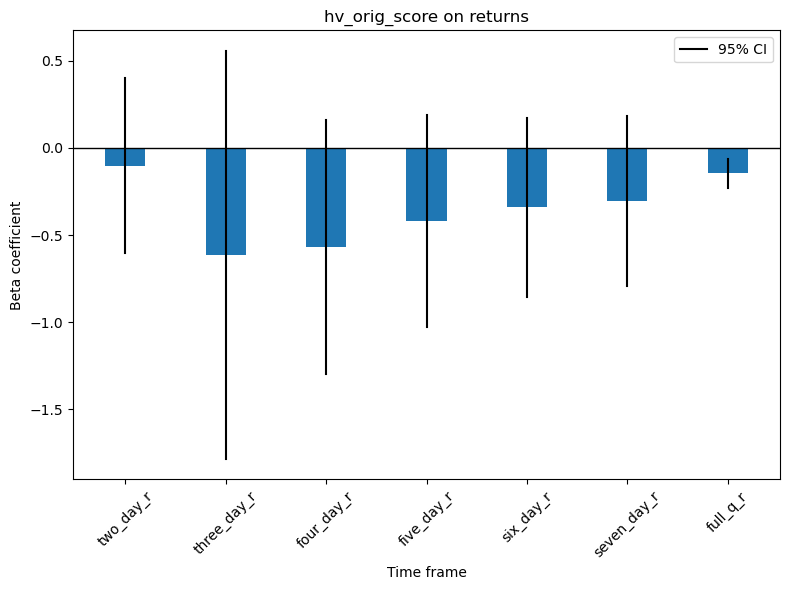

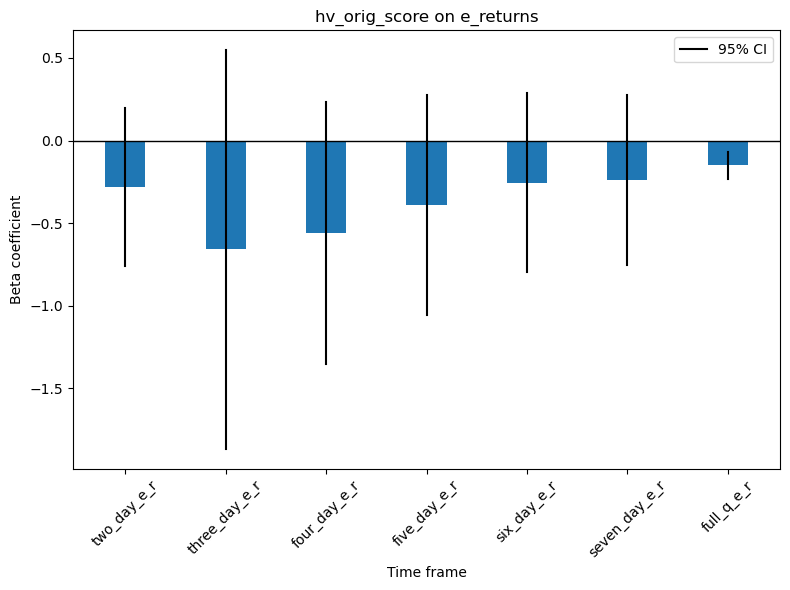

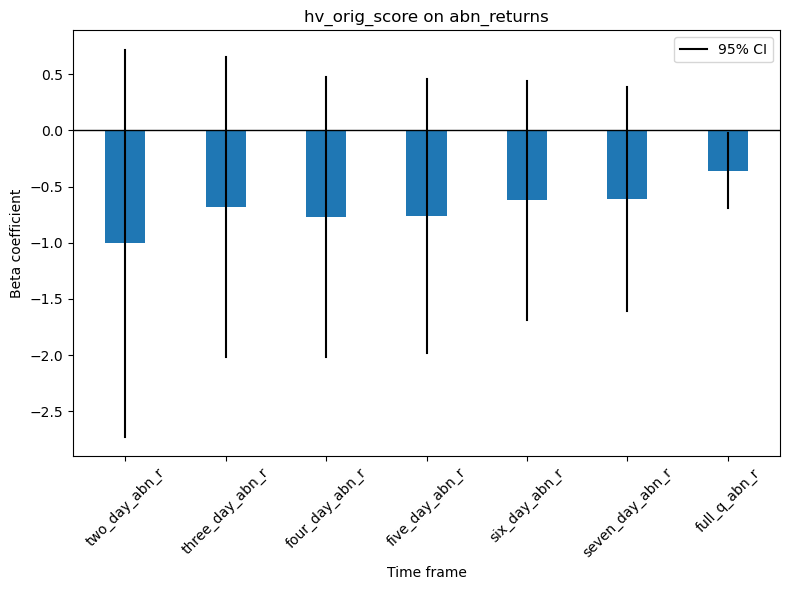

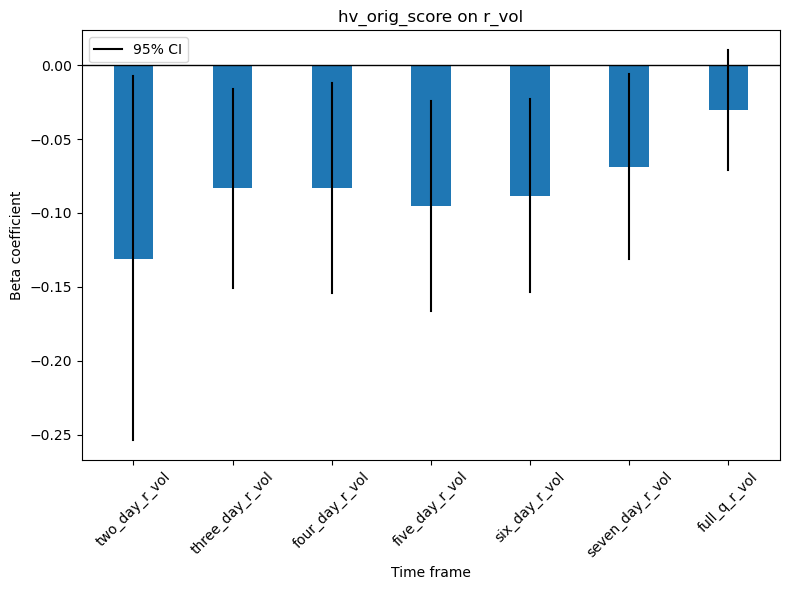

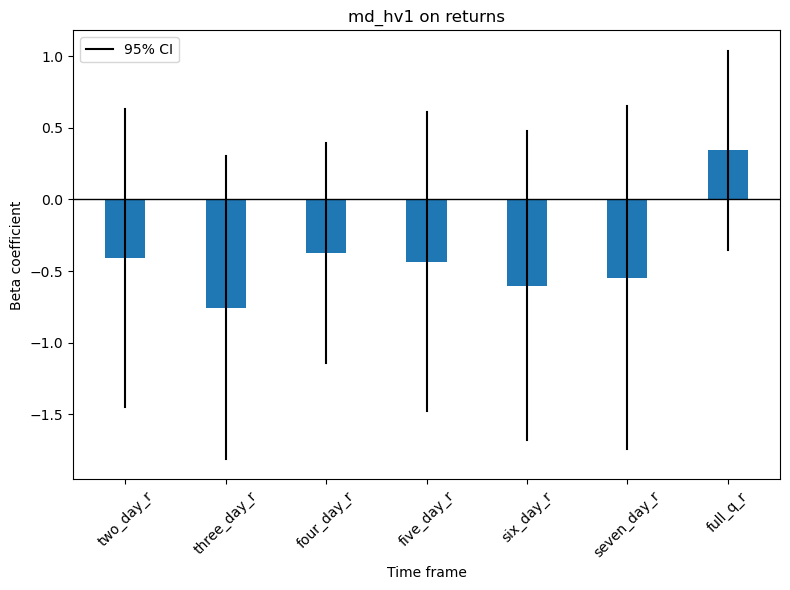

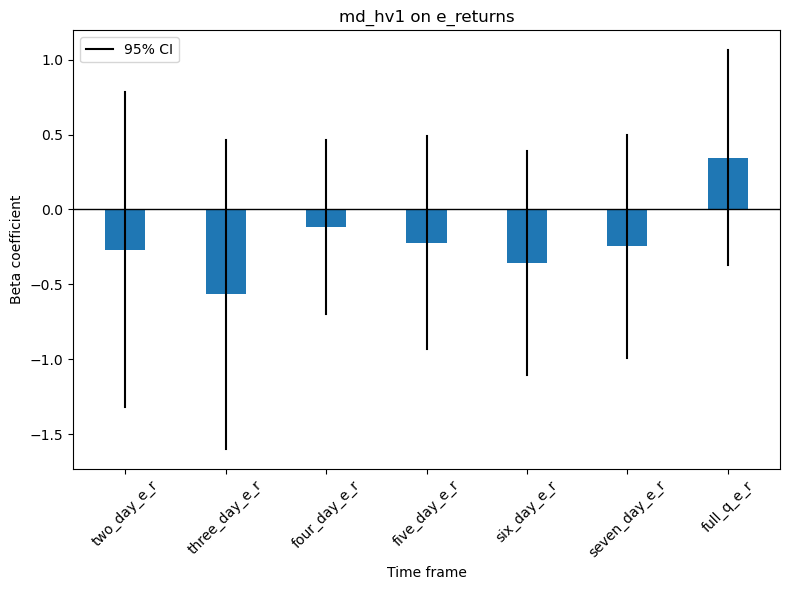

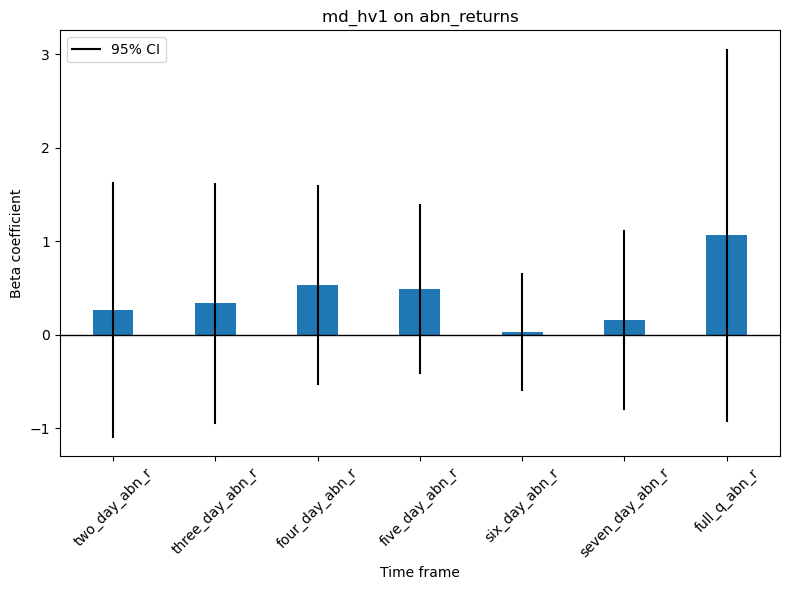

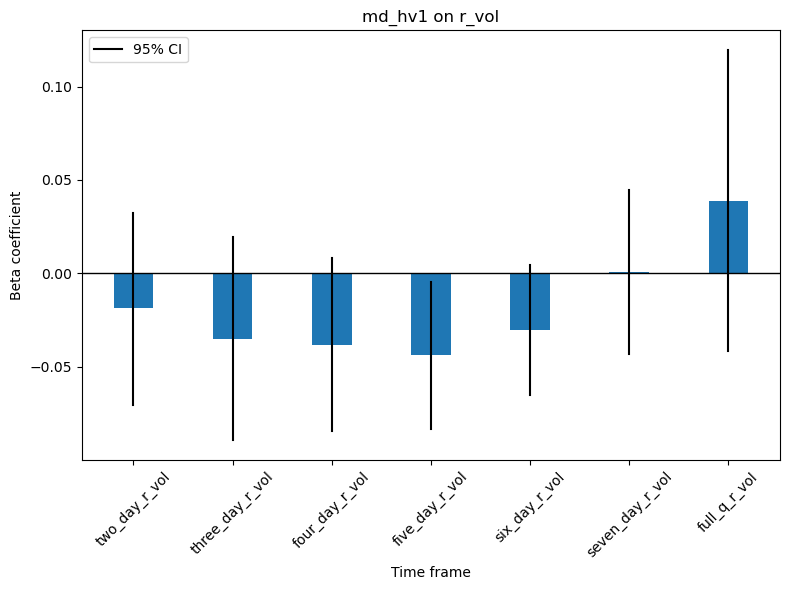

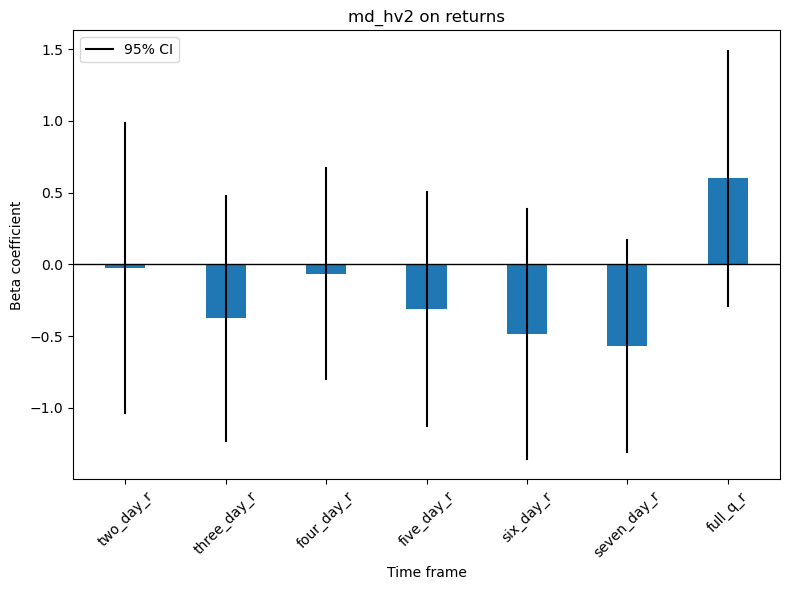

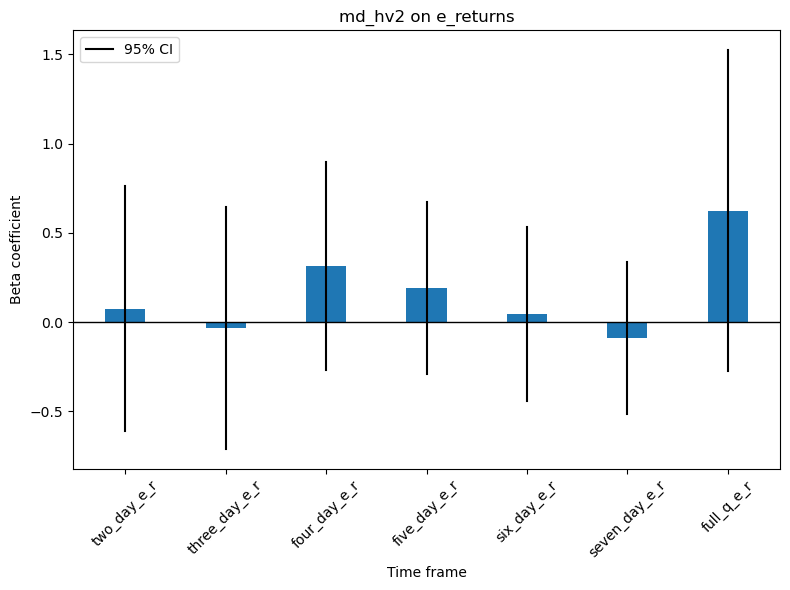

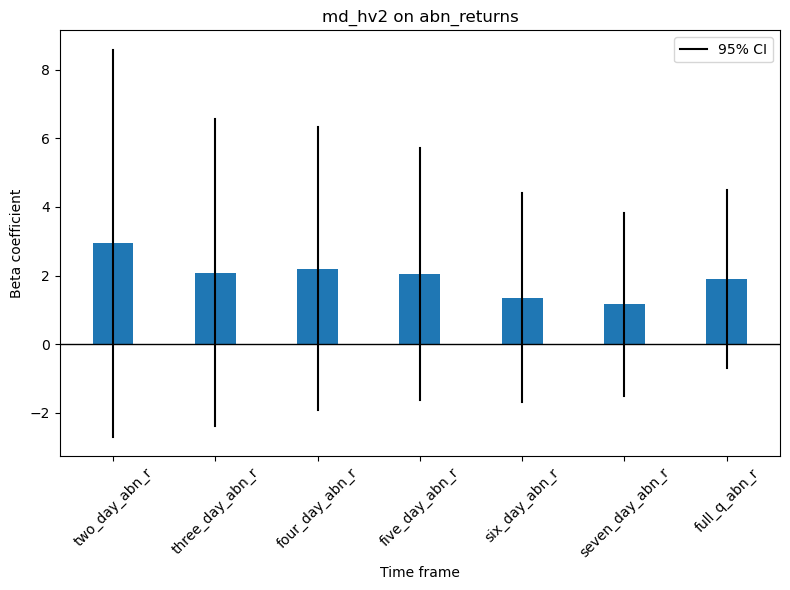

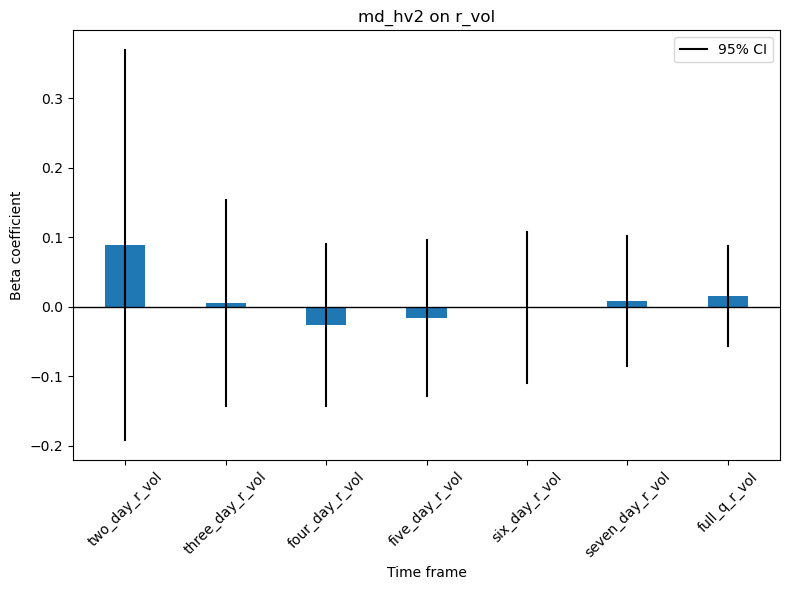

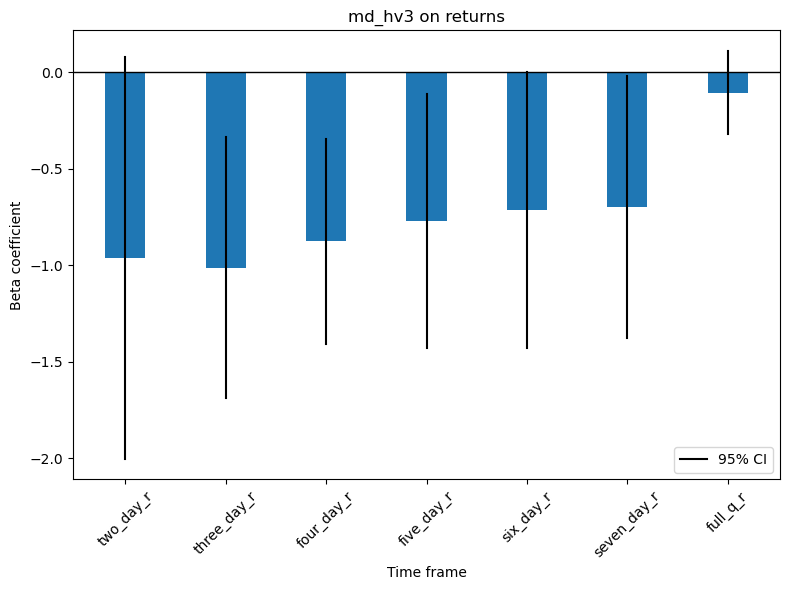

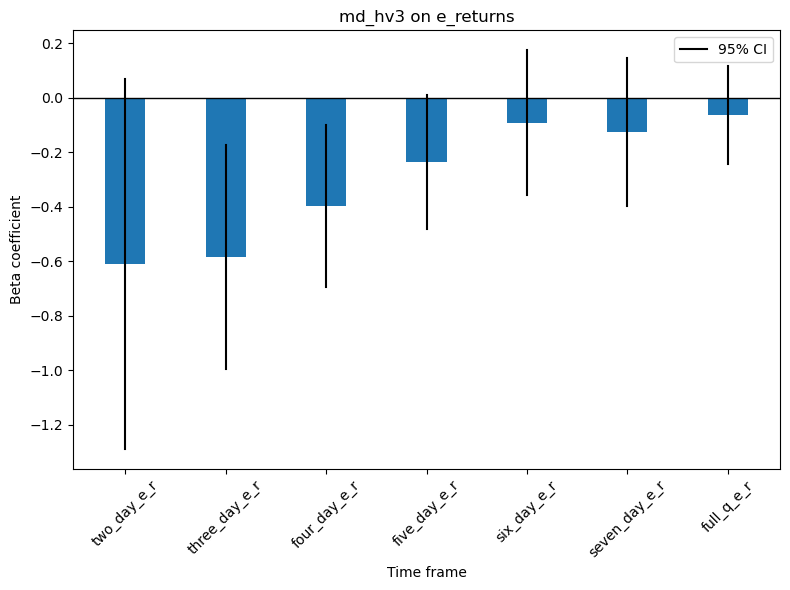

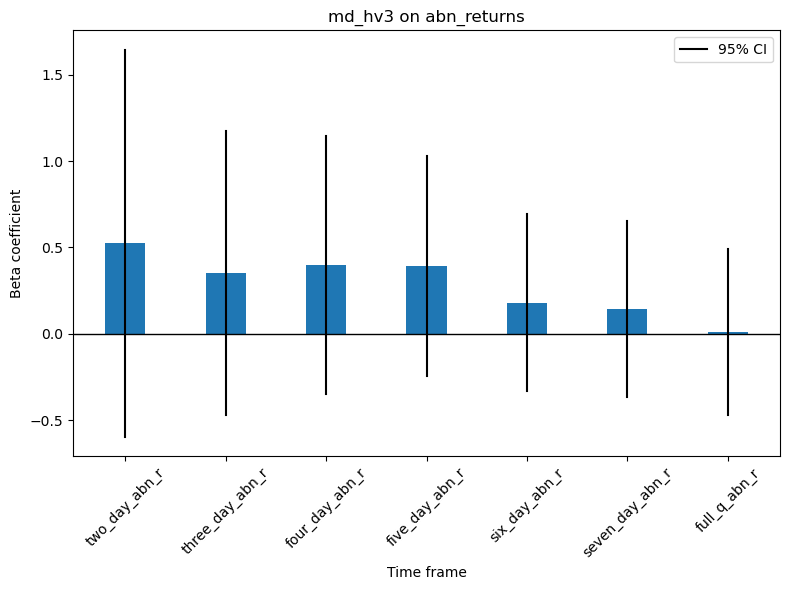

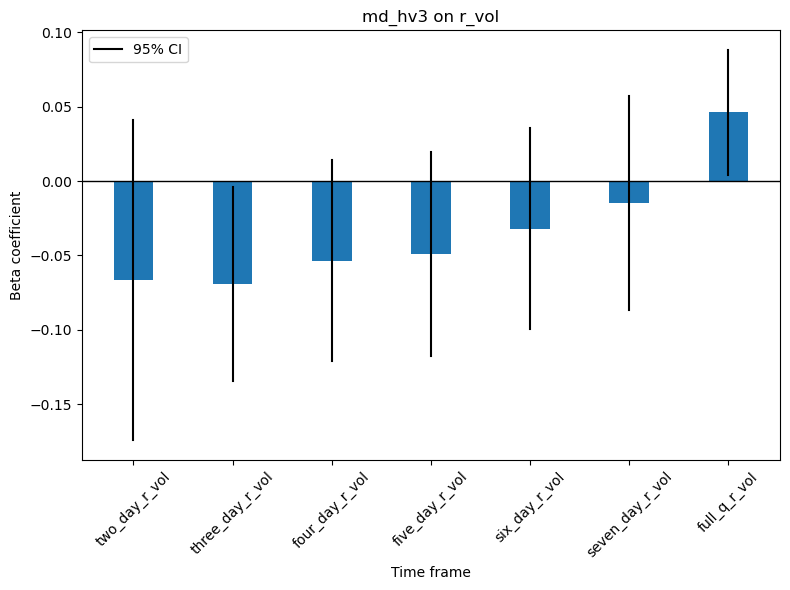

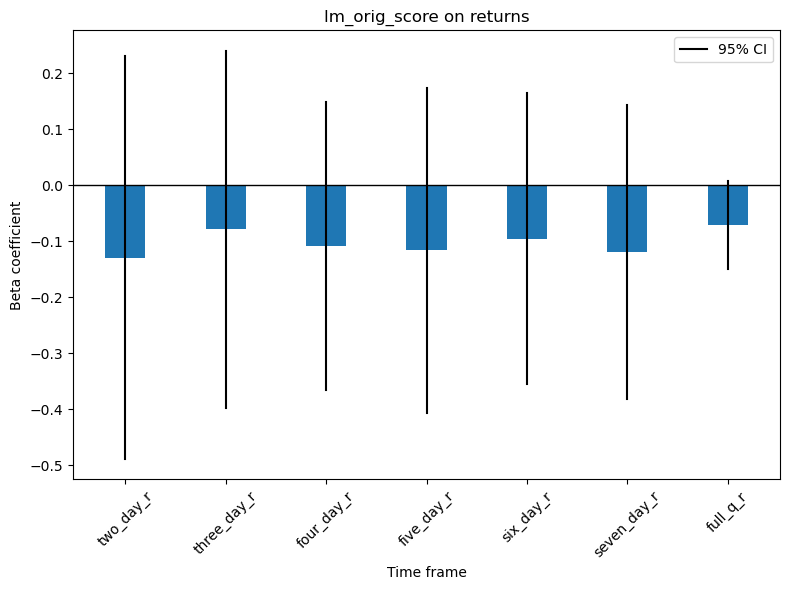

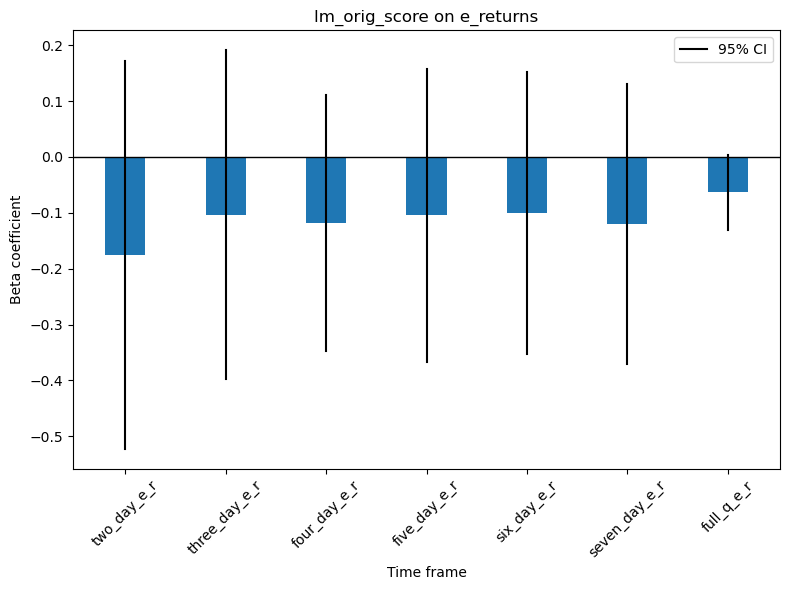

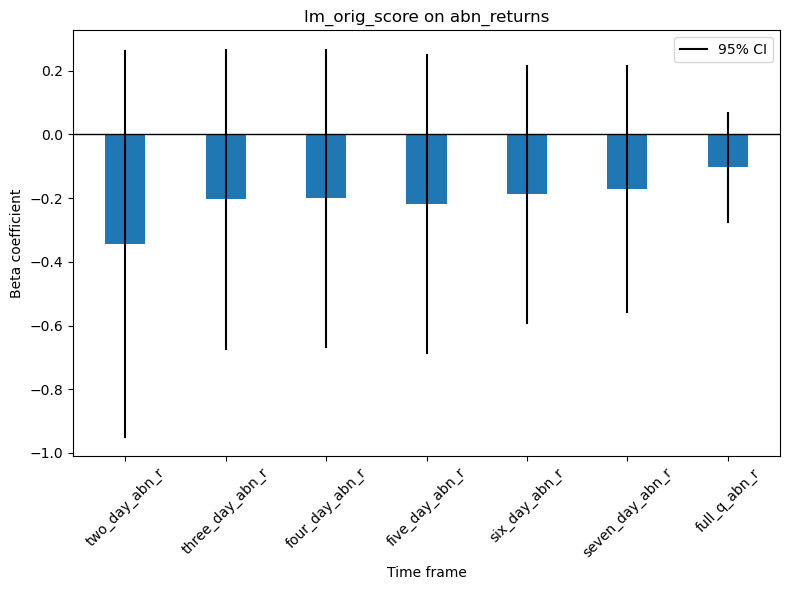

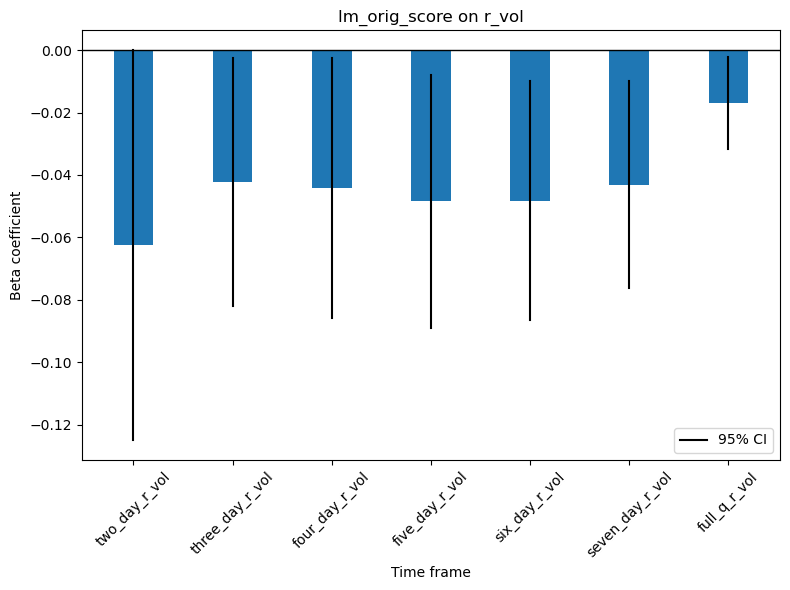

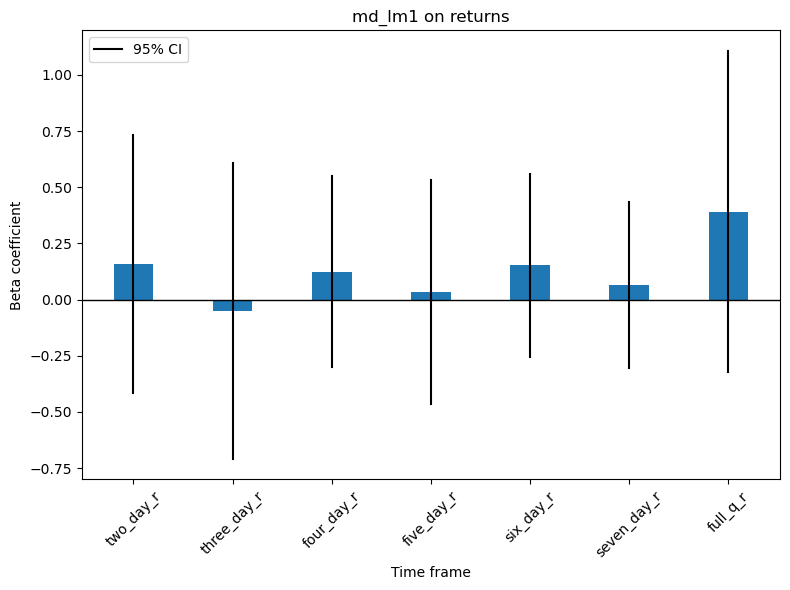

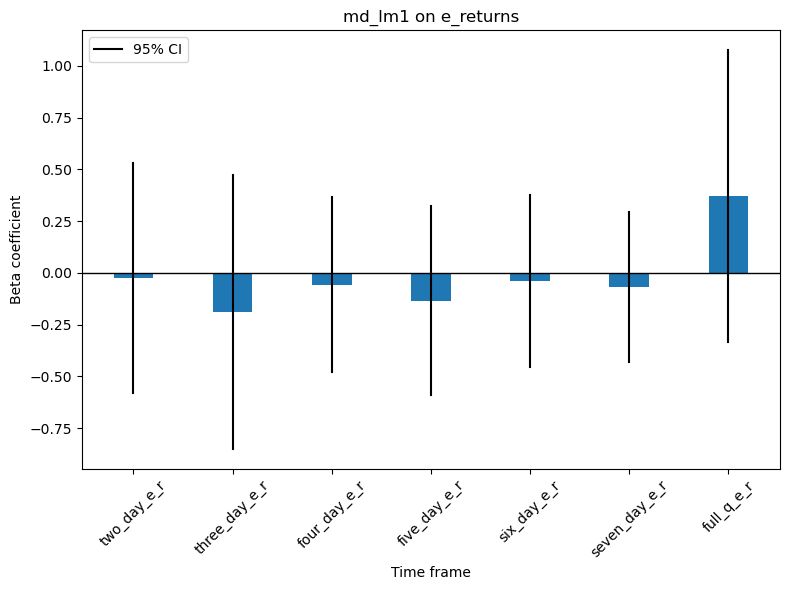

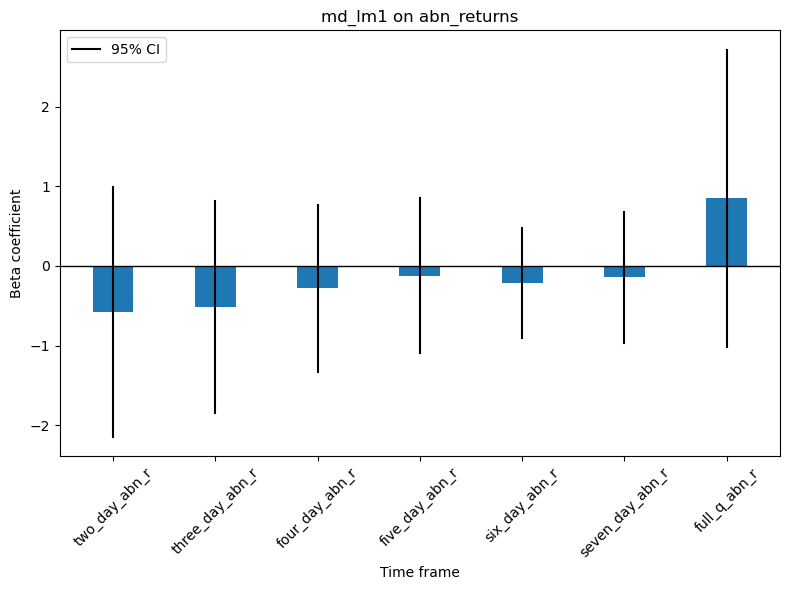

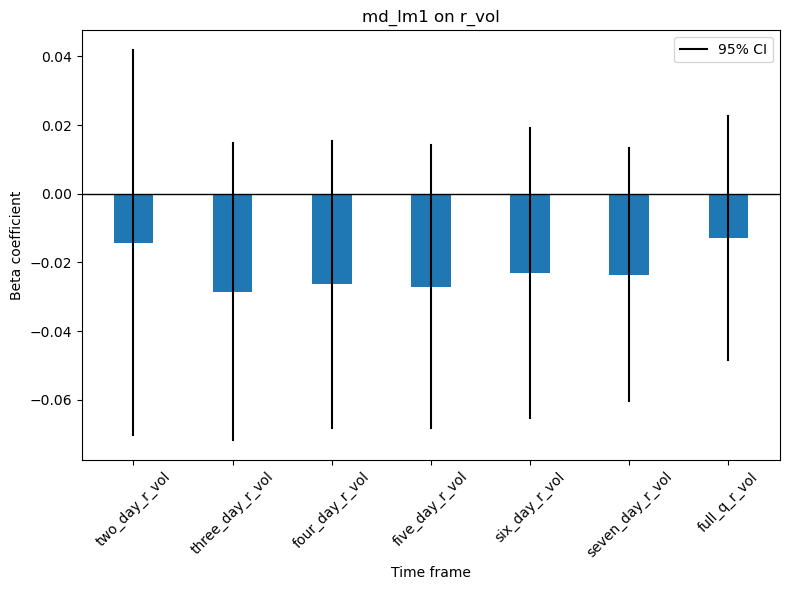

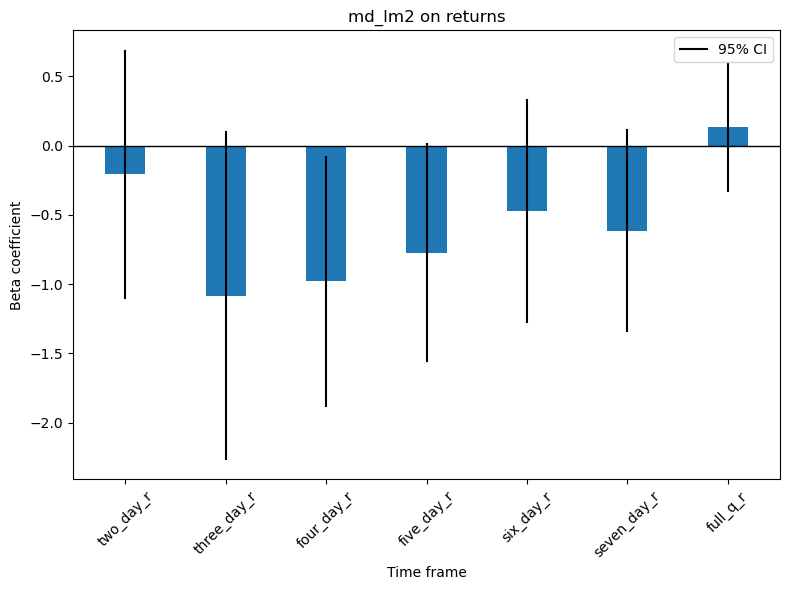

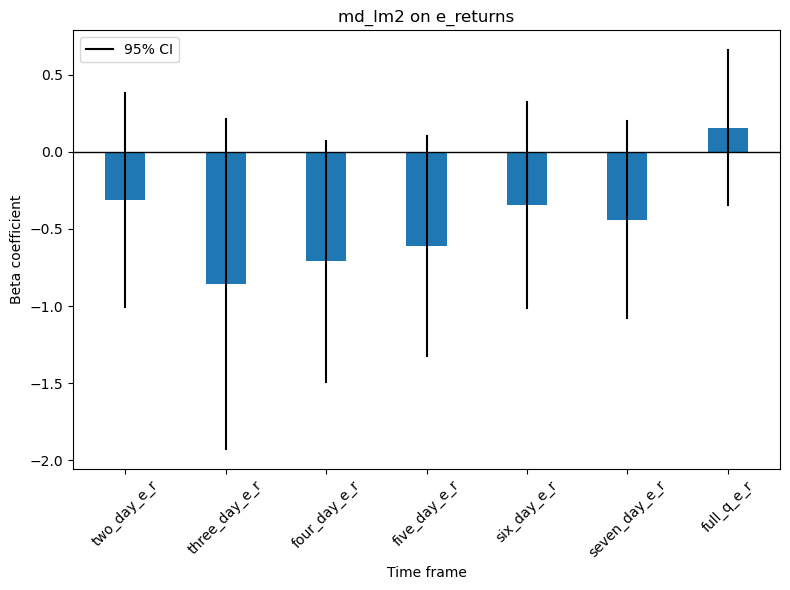

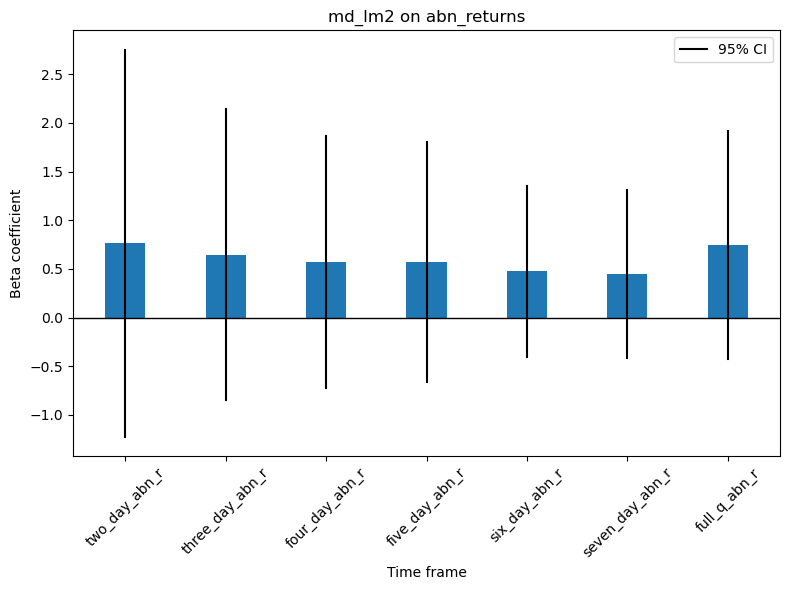

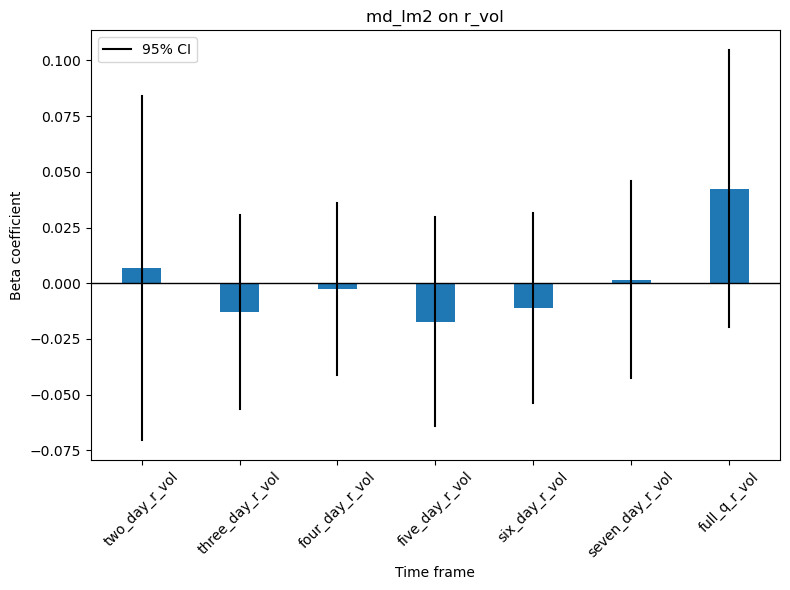

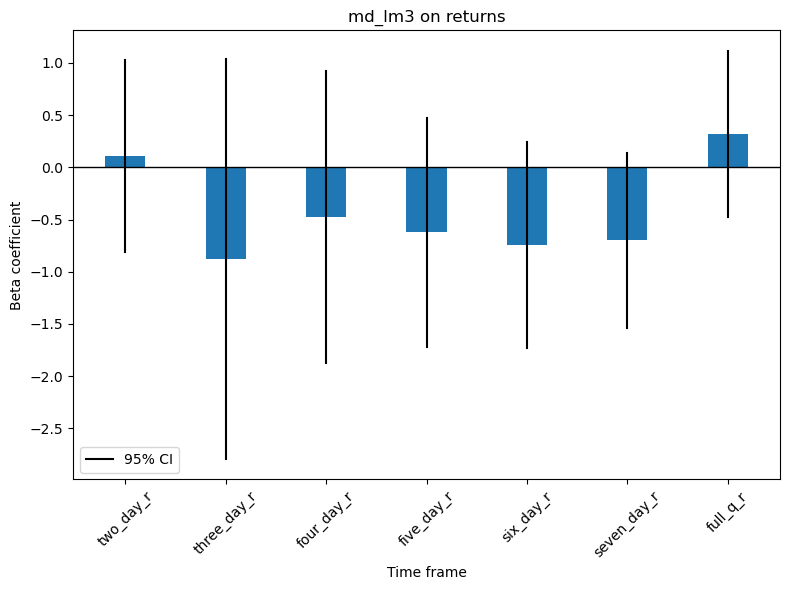

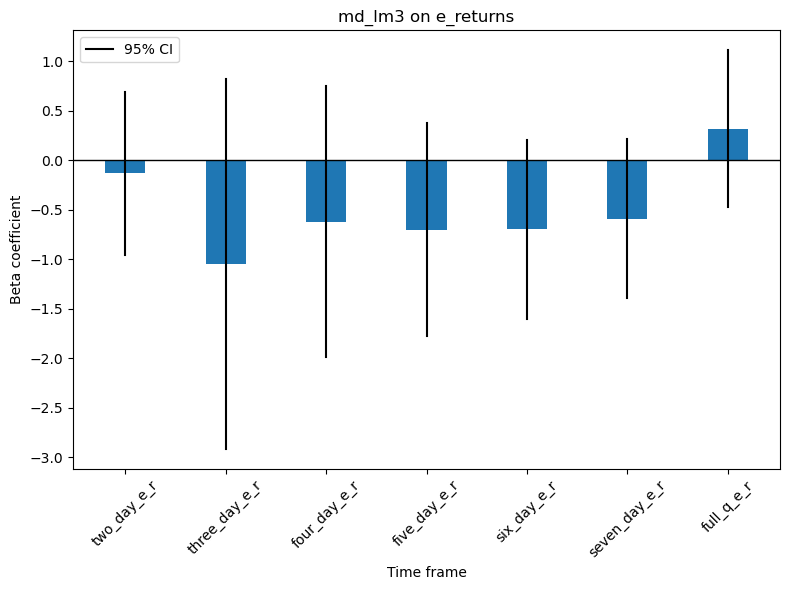

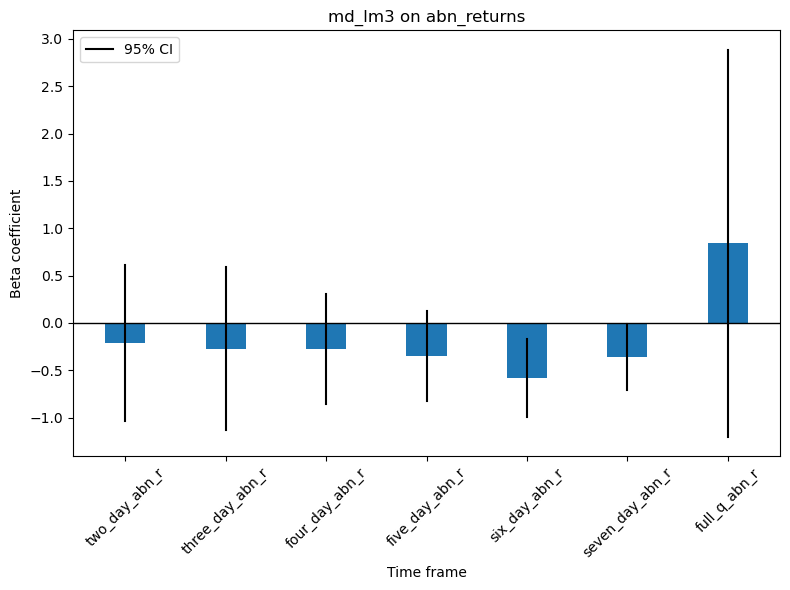

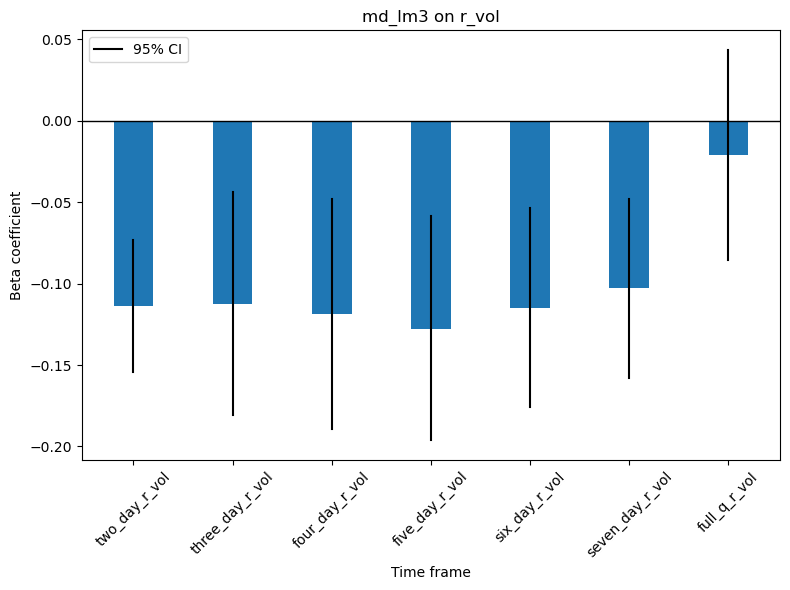

In [100]:
model.plot_all_params()